# NIPS Author Cluster Analysis:

## Abstract:
本報告為2018年下學期統計計算與模擬之期末報告，欲使用集群分析對高維度資料進行分群，並檢驗其效果。使用資料為NIPS(Conference and Workshop on Neural Information Processing Systems)從1987年到2017年的所有論文，資料包含論文id、作者id、以及論文全文，資料來源為kaggle(https://www.kaggle.com/benhamner/nips-papers) 。

透過文字分析技術，我們從文本中萃取出詞頻、詞性等特徵(feature)，接著篩選出論文數前10多的作者與其文章並進行標注。透過集群分析，試著將資料分群，檢驗分群結果是否能對應到十位作者、並計算其正確率(purity)，最後結果約為0.3至0.4。


***
## 1. Loading data and modules:

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import scipy
import itertools
import sklearn
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import metrics
%matplotlib inline
plt.style.use('ggplot')

#### 常數:
N : 欲分析之作者數(與分群數) <br>
SVD_N : SVD降維數 

In [10]:
N = 10
SVD_N = 100

In [20]:
papers = pd.read_csv("nips-papers/papers.csv")
authors = pd.read_csv('nips-papers/paper_authors.csv')

---
## 2. Find top N author clustering:


這次研究的目標是要透過分群結果檢視分群是否能對應(recover)原作者標籤，舉例來說，若有20位作者，就將論文分為20群，看看分群結果是否能把20位作者的論文都完美分到20群。然而，因為作者人數眾多(記9784人)，且多數論文都是多位作者共同著作，造成原資料難以透過集群去檢驗。因此，這裏我僅選出論文數量前十多的作者，將這十位作者所寫的論文記錄起來，並刪去十人之中有共筆的論文。換句話說，論文大多由複數位作者共筆，而我們篩選出的論文，作者其中之一必為這十人之一，但若十位作者中的作者A作者B共寫了某篇論文，則刪去該論文。最後這些論文共有460篇。

In [12]:
#論文數最多的前N名作者
top = sorted(Counter(authors.author_id).items(),key=lambda x:x[1],reverse=True)[0:N]
topauthor = [s[0] for s in top]
#找出這些作者對應的論文
paper_id = []
#for i in range(authors.shape[0]):
for author_id in topauthor:
    paper_id.append(list(authors.paper_id[authors.author_id==author_id].values))
paper_id = np.array(list(itertools.chain(*paper_id)))

#同篇作者可能會重複(例如，這N人中其中兩三人共寫某篇論文)，將這些論文它刪掉，使得每篇論文一定只屬於這N個作者中其中一人
## find papers that didnt have overlapped author
pid = set()
dup = set()
for i in paper_id:
    if i not in pid:
        pid.add(i)
    elif i in pid:
        dup.add(i)

#sel 為欲選取之篇章ID
sel = np.array(list(pid - dup))

#author_paper: 
author_paper = dict()
for author_id in topauthor:
    author_paper[author_id] = (list(authors.paper_id[authors.author_id==author_id].values))

#作者:文章 對應的字典，文章不重複
author_sel = dict()
for author,paperss in author_paper.items():
    temp = []
    for paper in paperss:
        if sel[np.where(sel==paper)]:
            temp.append(paper)
    author_sel[author] = temp

#ID 與 sparse matrix Row 的對照表:
#rowid 是原始sparse matrix的row對應的paper
temp = dict()
for i in range(papers.shape[0]):
    temp[papers.id[i]] = {"title":papers.title[i],"id":papers.id[i]}
temp = pd.DataFrame.from_dict(temp).transpose()
row_id = temp.index.values

#index : paper_id 對應到的 word_count sparse matrix 的row位置
index = [ np.where(row_id==i)[0][0] for i in sel]

# create author_series(paperid as index)
author_series = pd.Series(np.zeros(len(sel)))
author_series.index = sel
for a,ps in author_sel.items():
    for p in ps:
        try:
            author_series[p] = a
        except:
            print("fail at index: ",p)
len(index)            

460

In [47]:
print("Author ID : Paper Count:")
print(*[(author,len(paper)) for author,paper in author_sel.items()])

Author ID : Paper Count:
(330, 71) (1472, 49) (178, 60) (121, 50) (1020, 40) (54, 44) (632, 40) (3001, 41) (1410, 28) (191, 37)


***

## 3. Create Word Count table:
#### token,clean, and Stem
進行斷詞，清理，字尾處理，最後建立字數表與TF-IDF表

找到分群目標後，接下來就要試著從論文文本中找出能讓我們分群的特徵(feature)依據。由於文本資料為「非結構化的資料」，首先我們必須先試著將資料轉為我們熟悉的結構化資料。其中最簡單的方式，就是將論文切割為一個個的字詞作為變數，再利用向量空間模型(vector space model)來表達文字資料，其中每個column為一文件，每個row為字詞。

Vector space model說起來簡單，但實際做起來卻有很多的眉角與挑戰。首先在斷詞的部分，為了確實表達字詞意義，除了直接以空白切斷字詞，也可以使用n-gram的方式表達字詞。舉例而言，"fucking awesome"，若切為兩字，"fucking"看起來好像帶有負面意義，但兩字同時存在時，"fucking"卻是加強語氣，來強調超讚的意思。由於這組資料非常的大，對於8G ram的小筆電實在是很大的挑戰，所以這邊我們不考慮n-gram，僅以最簡單的單詞斷詞，去除掉停用詞(較無明確意義的字詞，例如me,the 等等)。接著再使用Porter Stemmer處理字尾的複數、過去式等型態，只保留帶有字詞意義的字根部分。

斷詞完後，接下來要考慮如何表達每個字詞向量的數值，最常見的表達方式有三種，其一為類別向量，字詞出現為1，不出現為0；其二為字詞數向量，向量值為該詞在論文中出現的次數； 最後為TF-IDF，除了用字詞數(TF)外，還利用IDF去調整字詞的權重。舉例來說，若某詞在多數論文都有出現，則給予較小的權重；反之，若有字詞只在數個文章中出現，即表示這個詞相對較為重要(在衡量文章相似性時)，因此給予較大的權重。此處我們選擇以TF-IDF表達，最後建立了(7241X213090)維的論文x字詞向量。

補充一提，由於VSM的矩陣多數數值都為0，在python中，我們可以使用scipy套件的sparse matrix去儲存矩陣，以節省記憶體空間。

In [ ]:
#This will take you about one hour to run
words_dict = {}
ps = PorterStemmer()
stop = set(stopwords.words('english'))
reg = re.compile("^[^\w\s|-|_]|[^\w\s\|-|_]$|[0-9]|^[a-z]$|^_")
#for i in range(10):
for i in range(papers.shape[0]):
    #stem and tokenize
    token_stem = [ps.stem(word) for word in word_tokenize(papers.paper_text[i].lower()) if word not in stop]
    #clean
    token_stem = [word for word in token_stem if not reg.search(word)]
    words_dict[(papers.id[i])] = dict(Counter(token_stem))

word_count_df = pd.DataFrame.from_dict(words_dict).transpose()
word_count_df =word_count_df.fillna(0)
rownames = word_count_df.index
# in case you blow up your fucking ram
del words_dict

# convert to sparse matrix
word_count_sparse = scipy.sparse.csr_matrix(word_count_df.values)

# TF-IDF
transformer = TfidfTransformer()
vsm_tfidf = transformer.fit_transform(word_count_df)

# save sparse matrix (again, in case you blow up your fucking ram)
#scipy.sparse.save_npz('/vsm_tfidf.npz', vsm_tfidf)
#scipy.sparse.save_npz('/tmp/word_count_sparse.npz', word_count_sparse)

***
## 4. Subset and SVD Decomposition:

由於vsm model維度極大，直接進行分類會造成運算上的困難，此外，許多資料檢索相關的文獻都提到，原始的vsm矩陣包含過多的雜訊(noise)，若不加以處理，分析結果通常不甚理想(Indexing by Latent Semantic Analysis,1990)。因此，這裡我們透過奇異值分解降維，只取前100維的orthogonal vector 表達我們的文章特徵，以達到我們維度縮減，並除去雜訊的目的。

In [15]:
vsm_subset = vsm_tfidf.toarray()[index,]
svd = TruncatedSVD(SVD_N)
vsm_subset_svd = svd.fit_transform(vsm_subset)

#降維後建立df
vsm_subset_svd_df = pd.DataFrame(vsm_subset_svd)
vsm_subset_svd_df.index = sel
vsm_subset_svd_df.index.name = "paper ID"

***
## 5. First try with Kmeans

完成了降維後，feature到手，希望無窮，接著我們就可以開始嘗試分群，首先從最簡單最經典的kmeans方法下手：
注意此處我們的accuracy(或稱purity)定義方法如下：設有$N$個觀測值，kmeans分群集群為$\Omega=(\omega_1,...)$，資料本來集群為 $C=(c_1,...)$，則可以定義purity為
$$Purity(\Omega,C) = \frac{1}{N}\Sigma_{k}max_j｜ \omega_k \cap c_j｜ $$

purity可以視為分群結果正確回復資料原本集群的比率，下面也列出了各集群分群正確的比率

In [96]:
kmeans = KMeans(N).fit(vsm_subset_svd_df)

#result DF:
res = author_series.to_frame(name="AuthorID")
res["cluster"] = kmeans.labels_

#result table:
res_cluster = res.groupby(['cluster',"AuthorID"]).size()
acc =[]

for i in set(res_cluster.index.get_level_values('cluster')):
    temp = res_cluster[i].sort_values(ascending=False)
    acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                temp.sum(),temp.iloc[0]/temp.sum()])
print("Accuracy : {}".format(sum(np.array(acc)[:,2])/len(res)),end="\n\n") 
print("Accuracy in each cluster:")
pd.DataFrame(acc,columns=["Cluster","Author","count","total","accuracy"])

Accuracy : 0.3347826086956522

Accuracy in each cluster:


,Cluster,Author,count,total,accuracy
0,0,121.0,24,67,0.358209
1,1,1472.0,14,28,0.500000
2,2,54.0,26,92,0.282609
3,3,330.0,11,30,0.366667
4,4,632.0,7,14,0.500000
5,5,121.0,9,31,0.290323
6,6,1020.0,26,80,0.325000
7,7,632.0,14,33,0.424242
8,8,1410.0,18,79,0.227848
9,9,178.0,5,6,0.833333


用數字看可能不清楚，接著透過圓餅圖，可以看出分類結果之混亂

/Users/hyades/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


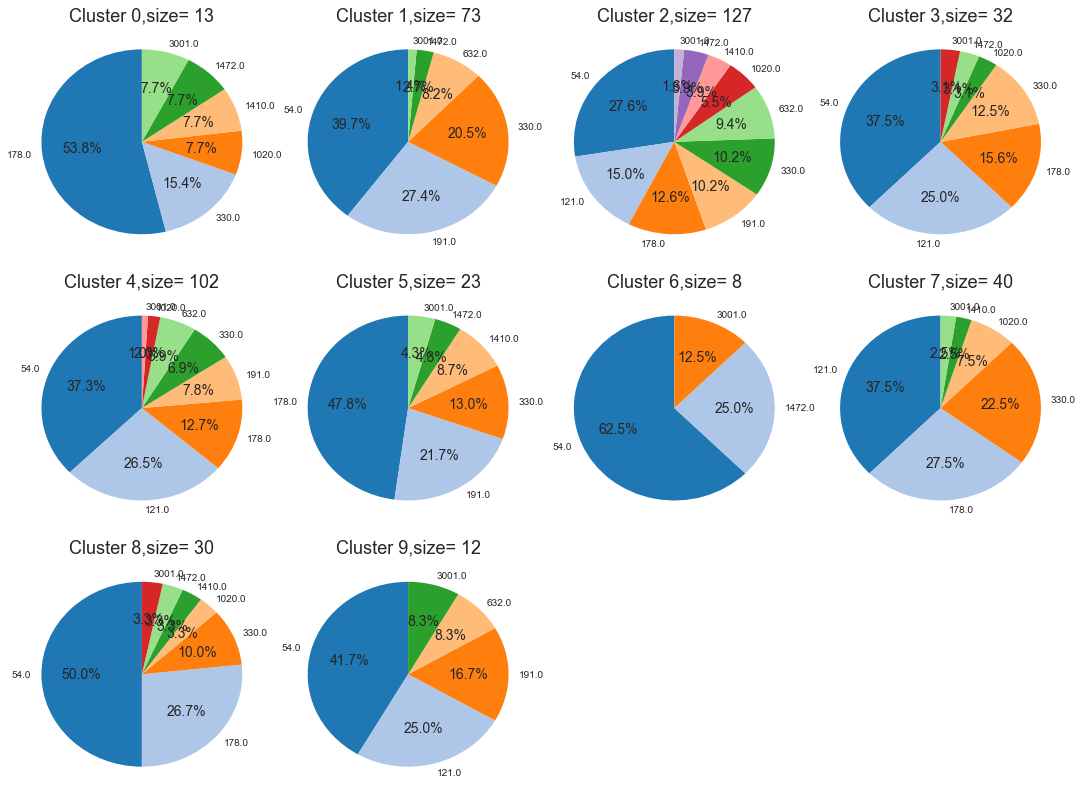

In [92]:
plt.style.use('seaborn')
plt.rcParams['font.size'] = 14
cm = plt.get_cmap('tab20')
temp = res.groupby(['cluster',"AuthorID"]).size()
fig = plt.figure(figsize=(15,15))
for i in range(kmeans.n_clusters):
    ax = fig.add_subplot(4,4,i+1)
    ax.set_color_cycle([cm(1.0*i/20) for i in range(20)])
    ax.pie(temp[i].sort_values(ascending=False),labels=temp[i].index,
           autopct='%1.1f%%',startangle=90)    
    ax.set_title("Cluster {},size= {}".format(i,temp[i].sum()),fontsize=18)
plt.tight_layout()
plt.savefig('kmeans.png')


***
## 6. Add other features:

既然現有的論文特徵矩陣無法有效的進行分類，接著我們嘗試從論文中找出更多的特徵，來協助改善我們的分群結果，特別是原本的vector space model無法表達的部分。  
#### 句數與句長：
若以換行符號去分割句子，並篩選出字元數大於10的句子(若小於10可能是notation或其他資訊)。透過這些句子，我們可以計算出「句數」、「平均句長(字元數)」、「字元數大於100的長句個數」等三個特徵。

#### POS詞性標記：
pos詞性標記是另一個在文本中可以萃取出的大量訊息，在文本分析中，也有人嘗試用poisson、negative binominal等機率分配去分析特定詞性或詞語的出現頻率。在眾多詞性中，我們特別關注於關係代名詞，介系詞，代詞等詞性。注意我們在建構vector space model前，已經先刪去了所謂的停用詞(即me,the,a等詞)，因此這邊我們嘗試去計算每種詞性在各篇論文中每句平均出現次數，作為各論文的詞性特徵向量。使用了八種詞性，因此多了八維的向量。

In [21]:
sent_dict = dict()
for i in sel:
    try:
        sent_dict[i] = [len(word) for word in papers.loc[papers.id==i,"paper_text"].values[0].split("\n") if len(word)>10]
    except:
        print("fail at :",i)
        
sent100_dict = dict()
for i in sel:
    try:
        sent_count = [len(word) for word in papers.loc[papers.id==i,"paper_text"].values[0].split("\n") if len(word)>100]
        sent100_dict[i] = len(sent_count)
    except:
        print("fail at :",i)

# convert to series:
sent_count = pd.Series({key:len(value) for key,value in sent_dict.items()},name="Sent_count")
sent_meanlen = pd.Series({key:np.mean(value) for key,value in sent_dict.items()},name="Sent_meanlen")
sent100 = pd.Series(sent100_dict,name="sent_over100_count")        

### POS table:

In [22]:
pos_sel = ['CC','DT','EX','IN','MD','WP','WRB','WDT']
pap_pos_dict = dict()
for i in sel:
    pos_dict = dict()
    pap = papers.loc[papers.id==i,"paper_text"].values[0]
    pap = word_tokenize(pap)
    pap = nltk.pos_tag(pap)
    n = sent_count[i]
    for p in pos_sel:
        # find how many word in this pos tag:
        pos_dict[p] = len([word for word,pos in pap if pos==p])/n
    pap_pos_dict[i] = pos_dict
pos = pd.DataFrame.from_dict(pap_pos_dict).transpose()    

## Combine Feature sets and weighting stragety

找出了特徵的矩陣後，我們將特徵與SVD的論文矩陣合併(merge)起來，組成新的特徵。這邊我們嘗試比較三種特徵的分群能力：
* SVD特徵
* SVD特徵+句子特徵
* SVD特徵+句子特徵+POS詞性特徵

值得一提的是，一般來說進行kmeans或其他分群時，會先將資料標準化，讓各個特徵處在差不多的「起點」，以避免尺度不同造成分群易受到尺度大的變數影響的狀況。但是反過來說，在我們合併維度差異很大的各種特徵組(feature set 組成的多維矩陣)時，如果不加以調整各特徵的權重(即尺度)，則無可避免的，分群結果會被維度較大的特徵組給宰制(dominate)。


以本例來說，3維的句子特徵，相對於100維的SVD論文特徵，就變得微不足道。因此，我們可以嘗試給予低維的特徵組較多的權重，至於給予多少權重就端看於個人對於各個特徵組的信心，分群本來就沒有固定答案，知道自己在幹嘛就好了。這邊我們將句子特徵標準化後，再把整個矩陣乘以3，給予句子特徵3倍的權重(因為句子特徵個別的分群能力也不錯)，而pos詞性特徵則不作調整。

In [23]:
WEIGHT=[3]*3
#WEIGHT = 2
feature = pd.concat([sent_count,sent_meanlen,sent100],axis=1)
feature = feature.loc[sel,:]
feature = pd.DataFrame(sklearn.preprocessing.normalize(feature),columns=feature.columns,index=feature.index)*WEIGHT
feature = pd.concat([feature,vsm_subset_svd_df],axis=1)

WEIGHT2 = [3]*3+[1]*8
feature_pos = pd.concat([sent_count,sent_meanlen,sent100,pos],axis=1)
feature_pos = feature_pos.loc[sel,:]
feature_pos = pd.DataFrame(sklearn.preprocessing.normalize(feature_pos),columns=feature_pos.columns,index=feature_pos.index)*WEIGHT2
feature_pos = pd.concat([feature_pos,vsm_subset_svd_df],axis=1)


#### Visualization of features : 

/Users/hyades/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


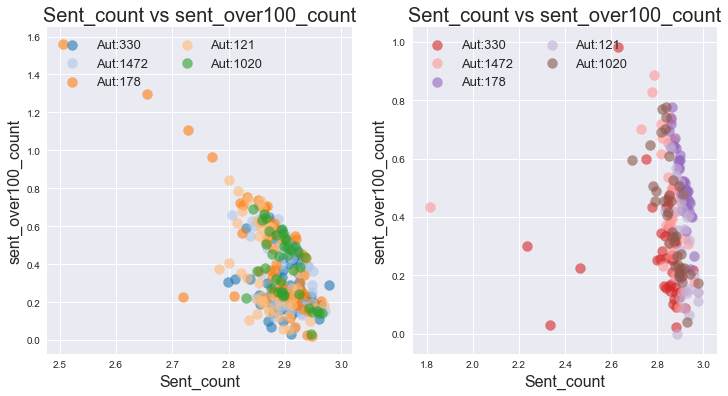

In [121]:
#set color cycle:
def plotscatter(x,y):
    cm = plt.get_cmap('tab20')
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(121)
    ax.set_color_cycle([cm(1.0*i/20) for i in range(20)])
    for key,value in list(author_sel.items())[0:5]:
        ax.scatter(x=feature.loc[value,x],
                   y=feature.loc[value,y],
                   s=100,alpha=0.6)
    ax.legend(["Aut:{}".format(key) for key in author_sel.keys()],loc="upper left",fontsize=13,ncol=2,shadow=True)
    ax.set_title("{} vs {}".format(x,y),fontsize=20)
    ax.set_xlabel(x,fontsize=16)
    ax.set_ylabel(y,fontsize=16)

    ax = fig.add_subplot(122)
    ax.set_color_cycle([cm(1.0*i/20+0.3) for i in range(20)])
    for key,value in list(author_sel.items())[5:10]:
        ax.scatter(x=feature.loc[value,x],
                   y=feature.loc[value,y],
                   s=100,alpha=0.6)
    ax.legend(["Aut:{}".format(key) for key in author_sel.keys()],loc="upper left",fontsize=13,ncol=2,shadow=True)
    ax.set_title("{} vs {}".format(x,y),fontsize=20)
    ax.set_xlabel(x,fontsize=16)
    ax.set_ylabel(y,fontsize=16)
plotscatter("Sent_count","sent_over100_count")    


***
## 7. Kmeans with other features:

In [94]:
kmeans = KMeans(N,n_init=10).fit(feature)
#result df
res = author_series.to_frame(name="AuthorID")
res["cluster"] = kmeans.labels_
#result by cluster:
res_cluster = res.groupby(['cluster',"AuthorID"]).size()
acc =[]
for i in set(res_cluster.index.get_level_values('cluster')):
    temp = res_cluster[i].sort_values(ascending=False)
    acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                temp.sum(),temp.iloc[0]/temp.sum()])
print("Accuracy: {:3f}".format(sum(np.array(acc)[:,2])/len(res)))


Accuracy: 0.328261


/Users/hyades/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


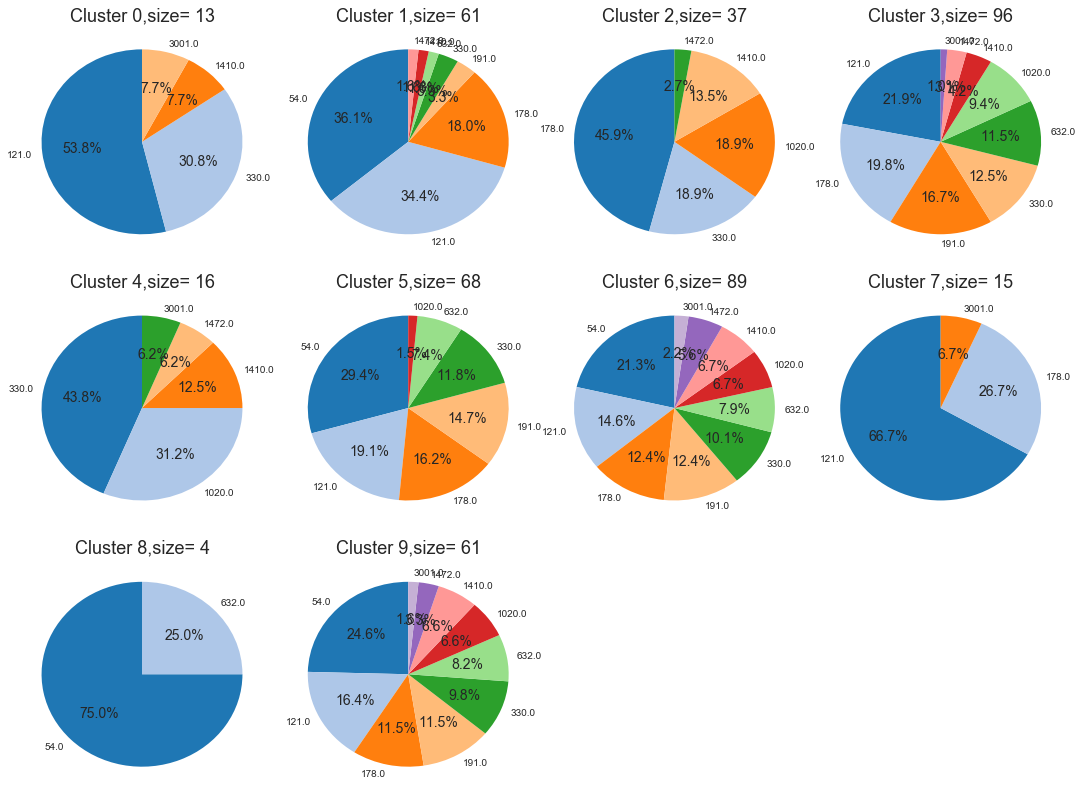

In [26]:
pd.DataFrame(acc,columns=["Cluster","Author","count","total","accuracy"])
plt.style.use('seaborn')
plt.rcParams['font.size'] = 14
temp = res.groupby(['cluster',"AuthorID"]).size()
fig = plt.figure(figsize=(15,15))
for i in range(kmeans.n_clusters):
    ax = fig.add_subplot(4,4,i+1)
    ax.set_color_cycle([cm(1.0*i/20) for i in range(20)])
    ax.pie(temp[i].sort_values(ascending=False),labels=temp[i].index,
           autopct='%1.1f%%',startangle=90)    
    ax.set_title("Cluster {},size= {}".format(i,temp[i].sum()),fontsize=18)
plt.tight_layout()

Still looks like shit.

***
## 8. EM 

接著我們嘗試使用EM去進行基於高斯混合模型的分群

In [27]:
em = GaussianMixture(n_components=10,n_init=10,covariance_type="full").fit(feature)
res = author_series.to_frame(name="AuthorID")
res["em"] = em.predict(feature)
#result by cluster:
res_cluster = res.groupby(['em',"AuthorID"]).size()
acc =[]
for i in set(res_cluster.index.get_level_values('em')):
    temp = res_cluster[i].sort_values(ascending=False)
    acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                temp.sum(),temp.iloc[0]/temp.sum()])
print("Accuracy: {:3f}".format(sum(np.array(acc)[:,2])/len(res)))

Accuracy: 0.356522


## Does additional features really make accuracy better ?

最後，我們想要比較不同特徵與不同方法下，各組的分群結果好壞。我們選擇正確率(purity)與silhouette作為準則，在前段所述的3組特徵下，使用EM與K-means，並比較其結果。

注意此處我們將分群各重複了1000次實驗，並比較其平均數與中位數。這是因為EM與kmeans皆涉及了隨機設定起始點開始分群，在高維度的資料下，若放寬迭代次數與錯誤率，則每次分群結果都會有所不同，造成每次的正確率與silhouette都會有所不同，因此重複實驗並比較平均數會是較為穩健的方法。當然，我們也可以嘗試對平均數或中位數進行檢定(常態或無母數)，但因為樣本很大(1000次的分群），基本上一定會拒絕，所以此處就不畫蛇添足。


In [28]:
def kmean_proc(data):
    kmeans = KMeans(N,n_init=10).fit(data)
    #result df
    res = author_series.to_frame(name="AuthorID")
    res["cluster"] = kmeans.labels_
    #result by cluster:
    res_cluster = res.groupby(['cluster',"AuthorID"]).size()
    acc =[]
    for i in set(res_cluster.index.get_level_values('cluster')):
        temp = res_cluster[i].sort_values(ascending=False)
        acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                    temp.sum(),temp.iloc[0]/temp.sum()])
    accuracy = sum(np.array(acc)[:,2])/len(res)
    silhouette = metrics.silhouette_score(data,labels=kmeans.labels_)
    return([accuracy,silhouette])

def em_proc(data):
    em = GaussianMixture(n_components=10,n_init=10,covariance_type="full").fit(data)
    res = author_series.to_frame(name="AuthorID")
    res["em"] = em.predict(data)
    #result by cluster:
    res_cluster = res.groupby(['em',"AuthorID"]).size()
    acc =[]
    for i in set(res_cluster.index.get_level_values('em')):
        temp = res_cluster[i].sort_values(ascending=False)
        acc.append([i,temp.iloc[0:1].index[0],temp.iloc[0],
                    temp.sum(),temp.iloc[0]/temp.sum()])
    accuracy = sum(np.array(acc)[:,2])/len(res)
    silhouette = metrics.silhouette_score(data,labels=em.predict(data))
    return([accuracy,silhouette])

In [31]:
emsvd = pd.DataFrame([em_proc(vsm_subset_svd_df) for i in range(1000)],
                     columns=["ems_acc","ems_silhouette"])

emf = pd.DataFrame([em_proc(feature) for i in range(1000)],
                   columns=["emf_acc","emf_silhouette"])

emfp = pd.DataFrame([em_proc(feature_pos) for i in range(1000)],
                   columns=["emfp_acc","emfp_silhouette"])

kmsvd = pd.DataFrame([kmean_proc(vsm_subset_svd_df) for i in range(1000)],
                     columns=["kms_acc","kms_silhouette"])

kmf = pd.DataFrame([kmean_proc(feature) for i in range(1000)],
                   columns=["kmf_acc","kmf_silhouette"])

kmfp = pd.DataFrame([kmean_proc(feature_pos) for i in range(1000)],
                   columns=["kmfp_acc","kmfp_silhouette"])

res = pd.concat([emsvd,emf,emfp,kmsvd,kmf,kmfp])

#### 比較分群的準確率

In [116]:
res.describe().iloc[[1,2,5],[True if re.search("acc",col) else False for col in res.columns]]

,emf_acc,emfp_acc,ems_acc,kmf_acc,kmfp_acc,kms_acc
mean,0.344730,0.344746,0.374126,0.335859,0.335900,0.370876
std,0.023549,0.022648,0.024004,0.021191,0.022856,0.023787
50%,0.343478,0.343478,0.373913,0.334783,0.334783,0.369565


#### 比較分群的silhouette

In [33]:
res.describe().iloc[[1,2,5],[True if re.search("silh",col) else False for col in res.columns]]

,emf_silhouette,emfp_silhouette,ems_silhouette,kmf_silhouette,kmfp_silhouette,kms_silhouette
mean,0.034518,0.034163,0.040515,0.043580,0.043380,0.047775
std,0.004908,0.004994,0.005111,0.004556,0.004696,0.004454
50%,0.034793,0.034539,0.041007,0.043669,0.043456,0.048234


大家可以看到，加入了更多特徵後，反而使得分群的準確率與silhouette都有所退步，實在是意料之外。

***
## 9. Conclusion

本次研究嘗試使用分群將作者分群，然而多位作者間可能都是研究相似領域，因此可能會寫出題目相近的論文，造成分群上的困難。若能知道個作者的研究方向，可能能進一步改善分群結果。(註：原始資料只有作者id，沒有作者名，只能比對多篇論文的共同作者才能回朔作者姓名，並進一步找出其領域，要花費不少心力)

此外，EM與K-means兩種方法再小型資料與本資料中，表現大致相同，沒有懸殊差距，惟silhouette通常K-means表現較佳，這與演算法本身的設計有關，詳細的比較方法與比較準則請參閱cluster_nips.pdf。